# Prepare MiDaS model

Mount Google drive 

In [1]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

FOLDERNAME = 'Colab Notebooks'

assert FOLDERNAME is not None, "[!] Enter the foldername."

Mounted at /content/drive


MiDaS depends on timm

In [2]:
pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 549 kB 24.5 MB/s 
     |████████████████████████████████| 182 kB 80.0 MB/s 


MiDaS depends on einops 

In [3]:
pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 540 kB/s 


Install Next-ViT for MiDaS

In [4]:
!git clone https://github.com/bytedance/Next-ViT.git externals/Next_ViT

Cloning into 'externals/Next_ViT'...
remote: Enumerating objects: 137, done.
remote: Counting objects: 100% (137/137), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 137 (delta 73), reused 109 (delta 48), pack-reused 0
Receiving objects: 100% (137/137), 5.36 MiB | 19.54 MiB/s, done.
Resolving deltas: 100% (73/73), done.


Example usage of MiDaS

In [5]:
import cv2
import torch
import urllib.request
import numpy as np

import matplotlib.pyplot as plt

url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "dog.jpg")
urllib.request.urlretrieve(url, filename)

('dog.jpg', <http.client.HTTPMessage at 0x7f1a0e317070>)

Load a model (see [https://github.com/intel-isl/MiDaS/#Accuracy](https://github.com/intel-isl/MiDaS/#Accuracy) for an overview)

In [6]:
model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
#model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
#model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)

midas = torch.hub.load("intel-isl/MiDaS", model_type)

/usr/local/lib/python3.8/dist-packages/torch/hub.py:267: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/intel-isl/MiDaS/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/isl-org/MiDaS/releases/download/v3/dpt_large_384.pt" to /root/.cache/torch/hub/checkpoints/dpt_large_384.pt


  0%|          | 0.00/1.28G [00:00<?, ?B/s]

Move model to GPU if available

In [7]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()

DPTDepthModel(
  (pretrained): Module(
    (model): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (norm_pre): Identity()
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=1024, out_features=1024, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): Identity()
          (drop_path1): Identity()
          (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=1024, out_features=4096, bias=True)
            (act): GELU(approximate='none')
            (d

Load transforms to resize and normalize the image for large or small model

In [8]:
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


Load image and apply transforms

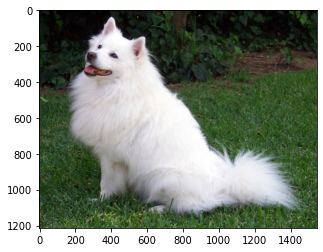

In [9]:
img = cv2.imread(filename)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

input_batch = transform(img).to(device)
plt.imshow(img)

Predict and resize to original resolution

In [10]:
with torch.no_grad():
    prediction = midas(input_batch)

    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

output = prediction.cpu().numpy()

Show result

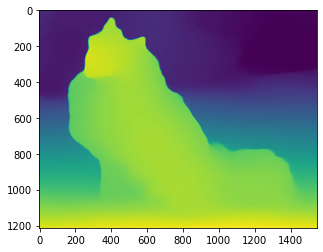

In [11]:
plt.imshow(output)
# plt.show()

# Refractive Error Image Processing 

## Prepare Image

Image loading

[4032, 3024]


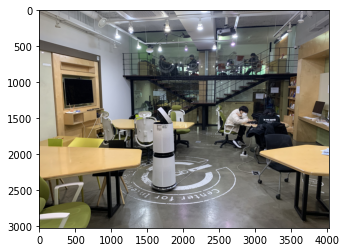

In [34]:
# use your own image url on Google Drive 
test_url = "/content/drive/MyDrive/Colab Notebooks/images/original/slab.jpg"
test_image = cv2.imread(test_url)
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
test_dim = [0,0]
test_dim[0] = test_image.shape[1]
test_dim[1] = test_image.shape[0]
print(test_dim)

plt.imshow(test_image)

Depth estimation

51.82364
1.1029524


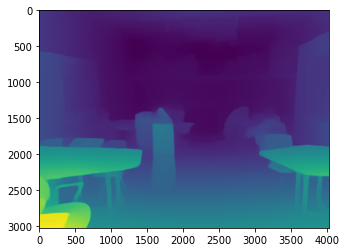

In [35]:
input_batch = transform(test_image).to(device)
with torch.no_grad():
    test_pred = midas(input_batch)

    test_pred = torch.nn.functional.interpolate(
        test_pred.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

test_output = test_pred.cpu().numpy()
test_output = cv2.resize(test_output, test_dim)
plt.imshow(test_output)

print(test_output.max())
print(test_output.min())

## Myopia Image

In [36]:
def apply_gaussian_filter(pixel_grid, sigma, size):
  kernel = np.array([0.0]*size) # 0 부터 size-1까지
  sum = 0.0
  list_i = range(0, size)
  row_size = pixel_grid.shape[0]
  column_size = pixel_grid.shape[1]

  after_filter_row = np.array([[[0.0,0.0,0.0] * 1] * column_size] * row_size)
  after_filter_column = np.array([[[0.0,0.0,0.0] * 1] * column_size] * row_size)

  for i in list_i:
      kernel[i] = np.exp(-((size//2 - i)**2)/(2*sigma**2))
      sum += kernel[i]
  kernel *= 1/sum # 1차원 kernel 생성

  # padded_array = np.pad(pixel_grid, ((size//2,size//2),(0,0),(0,0)), 'constant', constant_values=0.0)
  padded_array = np.pad(pixel_grid, ((size//2,size//2),(0,0),(0,0)), 'edge')

  for i in list_i:
      a = padded_array * kernel[i]
      after_filter_row += a[ i : row_size + i,0 : column_size,:]

  # padded_array = np.pad(after_filter_row, ((0,0),(size//2,size//2),(0,0)), 'constant', constant_values=0.0)
  padded_array = np.pad(after_filter_row, ((0,0),(size//2,size//2),(0,0)), 'edge')

  for i in list_i:
      a = padded_array * kernel[i]
      after_filter_column += a[0 : row_size, i : column_size + i,:]

  after_filter_column = after_filter_column.astype(np.uint8)
  return after_filter_column

In [37]:
def apply_myopia(image, depth_map, steps, strength):
  sigma = 1
  filter_size = 1
  filter_gap = 2 * strength
  sigma_gap = strength

  max_depth = np.max(depth_map)
  min_depth = np.min(depth_map)

  cut = np.zeros(steps-1)

  for i in range(steps-1):
    cut[i] = max_depth - (max_depth - min_depth) * (i+1) / steps
  
  depth_map = np.stack((depth_map, depth_map, depth_map) , axis = -1)

  output_image = np.zeros_like(image)

  # image_near
  output_image += np.where(depth_map >= cut[0], image, 0)

  image_far = apply_gaussian_filter(image, sigma + sigma_gap * (steps-1), filter_size + filter_gap*(steps-1))
  output_image += np.where(depth_map < cut[steps-2], image_far, 0)

  for i in range(steps-2):
    image_middle = apply_gaussian_filter(image, sigma + (i+1) * sigma_gap, filter_size + (i+1) * filter_gap)
    image_middle = np.where((depth_map < cut[i]) & (depth_map >= cut[i+1]), image_middle, 0)
    output_image += image_middle
  
  return output_image

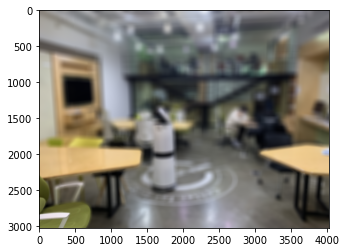

In [38]:
# myopia image generation
myopia_image_low = apply_myopia(test_image, test_output, 10, 2)
myopia_image_high = apply_myopia(test_image, test_output, 10, 6)
plt.imshow(myopia_image_high)

In [39]:
myopia_image_low = cv2.cvtColor(myopia_image_low, cv2.COLOR_BGR2RGB)
myopia_image_high = cv2.cvtColor(myopia_image_high, cv2.COLOR_BGR2RGB)
cv2.imwrite('/content/drive/MyDrive/Colab Notebooks/images/myopia_low.jpg', myopia_image_low)
cv2.imwrite('/content/drive/MyDrive/Colab Notebooks/images/myopia_high.jpg', myopia_image_high)

True

## Hyperopia Image

In [40]:
def apply_hyperopia(image, depth_map, steps, strength):
  sigma = 1
  filter_size = 1
  filter_gap = 2 * strength
  sigma_gap = strength

  max_depth = np.max(depth_map)
  min_depth = np.min(depth_map)

  cut = np.zeros(steps-1)

  for i in range(steps-1):
    cut[i] = min_depth + (max_depth - min_depth) * (i+1) / steps
  
  depth_map = np.stack((depth_map, depth_map, depth_map) , axis = -1)

  output_image = np.zeros_like(image)

  image_near = apply_gaussian_filter(image, sigma + sigma_gap*(steps-1), filter_size + filter_gap*(steps-1))
  output_image += np.where(depth_map >= cut[steps-2], image_near, 0)

  # image_far = apply_gaussian_filter(image, sigma, filter_size)
  output_image += np.where(depth_map < cut[0], image, 0)

  for i in range(steps-2):
    image_middle = apply_gaussian_filter(image, sigma + (i+1) * sigma_gap, filter_size + (i+1) * filter_gap)
    image_middle = np.where((depth_map >= cut[i]) & (depth_map < cut[i+1]), image_middle, 0)
    output_image += image_middle
  
  return output_image

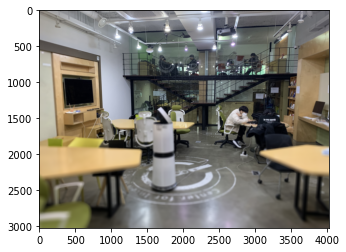

In [41]:
# hyperopia image generation
hyperopia_image_low = apply_hyperopia(test_image, test_output, 10, 2)
hyperopia_image_high = apply_hyperopia(test_image, test_output, 10, 6)
plt.imshow(hyperopia_image_high)

In [42]:
hyperopia_image_low = cv2.cvtColor(hyperopia_image_low, cv2.COLOR_BGR2RGB)
hyperopia_image_high = cv2.cvtColor(hyperopia_image_high, cv2.COLOR_BGR2RGB)
cv2.imwrite('/content/drive/MyDrive/Colab Notebooks/images/hyperopia_low.jpg', hyperopia_image_low)
cv2.imwrite('/content/drive/MyDrive/Colab Notebooks/images/hyperopia_high.jpg', hyperopia_image_high)

True

## With-the-rule Astigmatism with Myopia Image

In [43]:
def apply_wtr_astigmatism_filter(pixel_grid, size):
  kernel = np.array([0.5/size]*2*size) # 0 부터 size-1까지
  row_size = pixel_grid.shape[0]
  column_size = pixel_grid.shape[1]

  after_filter_row = np.array([[[0.0,0.0,0.0] * 1] * column_size] * row_size)

  padded_array = np.pad(pixel_grid, ((size,size),(0,0),(0,0)), 'reflect')

  for i in range(0, 2*size):
      a = padded_array * kernel[i]
      after_filter_row += a[ i : row_size + i,0 : column_size,:]

  after_filter_row = after_filter_row.astype(np.uint8)
  return after_filter_row

In [44]:
def apply_wtr_astigmatism(image, depth_map, steps, initial_value, strength):
  filter_size = initial_value
  filter_gap = strength

  max_depth = np.max(depth_map)
  min_depth = np.min(depth_map)

  cut = np.zeros(steps-1)

  for i in range(steps-1):
    cut[i] = max_depth - (max_depth - min_depth) * (i+1) / steps
  
  depth_map = np.stack((depth_map, depth_map, depth_map) , axis = -1)

  output_image = np.zeros_like(image)

  # image_near
  image_near = apply_wtr_astigmatism_filter(image, filter_size)
  output_image += np.where(depth_map >= cut[0], image_near, 0)

  image_far = apply_wtr_astigmatism_filter(image, filter_size + filter_gap*(steps-1))
  output_image += np.where(depth_map < cut[steps-2], image_far, 0)

  for i in range(steps-2):
    image_middle = apply_wtr_astigmatism_filter(image, filter_size + (i+1) * filter_gap)
    image_middle = np.where((depth_map < cut[i]) & (depth_map >= cut[i+1]), image_middle, 0)
    output_image += image_middle
  
  return output_image

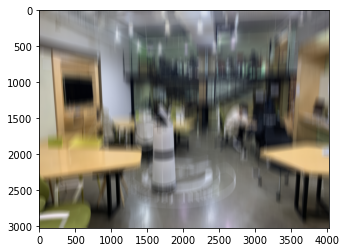

In [45]:
# wtr astigmatism image generation
wtr_astigmatism_image_low = apply_wtr_astigmatism(test_image, test_output, 10, 7, 2)
wtr_astigmatism_image_high = apply_wtr_astigmatism(test_image, test_output, 10, 30, 6)
plt.imshow(wtr_astigmatism_image_high)

In [ ]:
wtr_astigmatism_image_low = cv2.cvtColor(wtr_astigmatism_image_low, cv2.COLOR_BGR2RGB)
wtr_astigmatism_image_high = cv2.cvtColor(wtr_astigmatism_image_high, cv2.COLOR_BGR2RGB)
cv2.imwrite('/content/drive/MyDrive/Colab Notebooks/images/wtr_astigmatism_low.jpg', wtr_astigmatism_image_low)
cv2.imwrite('/content/drive/MyDrive/Colab Notebooks/images/wtr_astigmatism_high.jpg', wtr_astigmatism_image_high)

## Against-the-rule Astigmatism with Hyperopia Image

In [ ]:
def apply_atr_astigmatism_filter(pixel_grid, size):
  kernel = np.array([0.5/size]*2*size) # 0 부터 size-1까지
  row_size = pixel_grid.shape[0]
  column_size = pixel_grid.shape[1]

  after_filter_column = np.array([[[0.0,0.0,0.0] * 1] * column_size] * row_size)

  padded_array = np.pad(pixel_grid, ((0,0),(size,size),(0,0)), 'reflect')

  for i in range(0, 2*size):
      a = padded_array * kernel[i]
      after_filter_column += a[ 0 : row_size,i : column_size + i,:]

  after_filter_column = after_filter_column.astype(np.uint8)
  return after_filter_column

In [ ]:
def apply_atr_astigmatism(image, depth_map, steps, initial_value, strength):
  filter_size = initial_value
  filter_gap = strength

  max_depth = np.max(depth_map)
  min_depth = np.min(depth_map)

  cut = np.zeros(steps-1)

  for i in range(steps-1):
    cut[i] = min_depth + (max_depth - min_depth) * (i+1) / steps
  
  depth_map = np.stack((depth_map, depth_map, depth_map) , axis = -1)

  output_image = np.zeros_like(image)

  image_near = apply_atr_astigmatism_filter(image, filter_size + filter_gap*(steps-1))
  output_image += np.where(depth_map >= cut[steps-2], image_near, 0)

  image_far = apply_atr_astigmatism_filter(image, filter_size)
  output_image += np.where(depth_map < cut[0], image_far, 0)

  for i in range(steps-2):
    image_middle = apply_atr_astigmatism_filter(image, filter_size + (i+1) * filter_gap)
    image_middle = np.where((depth_map >= cut[i]) & (depth_map < cut[i+1]), image_middle, 0)
    output_image += image_middle
  
  return output_image

In [ ]:
# atr astigmatism image generation
atr_astigmatism_image_low = apply_atr_astigmatism(test_image, test_output, 10, 7, 2)
atr_astigmatism_image_high = apply_atr_astigmatism(test_image, test_output, 10, 10, 6)
plt.imshow(atr_astigmatism_image_high)

In [50]:
atr_astigmatism_image_low = cv2.cvtColor(atr_astigmatism_image_low, cv2.COLOR_BGR2RGB)
atr_astigmatism_image_high = cv2.cvtColor(atr_astigmatism_image_high, cv2.COLOR_BGR2RGB)
cv2.imwrite('/content/drive/MyDrive/Colab Notebooks/images/atr_astigmatism_low.jpg', atr_astigmatism_image_low)
cv2.imwrite('/content/drive/MyDrive/Colab Notebooks/images/atr_astigmatism_high.jpg', atr_astigmatism_image_high)

True

## Irregular Astigmatism Image

In [ ]:
def apply_irregular_filter(pixel_grid, size):
  row_size = pixel_grid.shape[0]
  column_size = pixel_grid.shape[1]

  output_image = np.array([[[0.0,0.0,0.0] * 1] * column_size] * row_size)

  padded_array = np.pad(pixel_grid, ((size,size),(size,size),(0,0)), 'reflect')

  output_image += 0.12* padded_array[ 0 : row_size,0 : column_size,:]
  output_image += 0.27* padded_array[ 2*size : 2*size + row_size,0 : column_size,:]
  output_image += 0.21* padded_array[ 2*size : 2*size + row_size,2*size : 2*size + column_size,:]
  output_image += 0.10* padded_array[ 0 : row_size,2*size : 2*size + column_size,:]
  output_image += 0.30* padded_array[ size : size + row_size,size : size + column_size,:]

  output_image = output_image.astype(np.uint8)
  return output_image

In [ ]:
def apply_irr_astigmatism(image, depth_map, steps, initial_value, strength):
  filter_size = initial_value
  filter_gap = strength

  max_depth = np.max(depth_map)
  min_depth = np.min(depth_map)

  cut = np.zeros(steps-1)

  for i in range(steps-1):
    cut[i] = max_depth - (max_depth - min_depth) * (i+1) / steps
  
  depth_map = np.stack((depth_map, depth_map, depth_map) , axis = -1)

  output_image = np.zeros_like(image)

  # image_near
  image_near = apply_irregular_filter(image, filter_size)
  output_image += np.where(depth_map >= cut[0], image_near, 0)

  image_far = apply_irregular_filter(image, filter_size + filter_gap*(steps-1))
  output_image += np.where(depth_map < cut[steps-2], image_far, 0)

  for i in range(steps-2):
    image_middle = apply_irregular_filter(image, filter_size + (i+1) * filter_gap)
    image_middle = np.where((depth_map < cut[i]) & (depth_map >= cut[i+1]), image_middle, 0)
    output_image += image_middle
  
  return output_image

In [ ]:
# irr astigmatism image generation
irr_astigmatism_image_low = apply_irr_astigmatism(test_image, test_output, 10, 7, 2)
irr_astigmatism_image_high = apply_irr_astigmatism(test_image, test_output, 10, 25, 1)
plt.imshow(irr_astigmatism_image_high)

In [54]:
irr_astigmatism_image_low = cv2.cvtColor(irr_astigmatism_image_low, cv2.COLOR_BGR2RGB)
irr_astigmatism_image_high = cv2.cvtColor(irr_astigmatism_image_high, cv2.COLOR_BGR2RGB)
cv2.imwrite('/content/drive/MyDrive/Colab Notebooks/images/irr_astigmatism_low.jpg', irr_astigmatism_image_low)
cv2.imwrite('/content/drive/MyDrive/Colab Notebooks/images/irr_astigmatism_high.jpg', irr_astigmatism_image_high)

True

True